In [1]:
# Adapted from: https://stackoverflow.com/questions/14084634/adaptive-plotting-of-a-function-in-python
# Old license: "Adaptive sampling of 1D functions" by unknown CC0

# Modified by Thomas Ferreira de Lima @thomaslima
# License: CC BY 4.0 https://creativecommons.org/licenses/by/4.0/

import numpy as np


def sample_function(func, points, tol=0.001, min_points=8, max_level=16,
                    sample_transform=None):
    """
    Sample a 1D function to given tolerance by adaptive subdivision.

    The function itself can be multidimensional.

    The result of sampling is a set of points that, if plotted,
    produces a smooth curve with also sharp features of the function
    resolved.

    Parameters
    ----------
    func : callable
        Function func(x) of a single argument. It is assumed to be vectorized.
    points : array-like, 1D
        Initial points to sample, sorted in ascending order.
        These will determine also the bounds of sampling.
    tol : float, optional
        Tolerance to sample to. The condition is roughly that the total
        length of the curve on the (x, y) plane is computed up to this
        tolerance.
    min_point : int, optional
        Minimum number of points to sample.
    max_level : int, optional
        Maximum subdivision depth.
    sample_transform : callable, optional
        Function w = g(x, y). The x-samples are generated so that w
        is sampled.

    Returns
    -------
    x : ndarray
        X-coordinates
    y : ndarray
        Corresponding values of func(x)

    Notes
    -----
    This routine is useful in computing functions that are expensive
    to compute, and have sharp features --- it makes more sense to
    adaptively dedicate more sampling points for the sharp features
    than the smooth parts.

    Examples
    --------
    >>> def func(x):
    ...     '''Function with a sharp peak on a smooth background'''
    ...     a = 0.001
    ...     return x + a**2/(a**2 + x**2)
    ...
    >>> x, y = sample_function(func, [-1, 1], tol=1e-3)

    >>> import matplotlib.pyplot as plt
    >>> xx = np.linspace(-1, 1, 12000)
    >>> plt.plot(xx, func(xx), '-', x, y[0], '.')
    >>> plt.show()

    """
    with np.errstate(divide='ignore', invalid='ignore'):
        return _sample_function(func, points, values=None, mask=None, depth=0,
                                tol=tol, min_points=min_points, max_level=max_level,
                                sample_transform=sample_transform)


def _sample_function(func, points, values=None, mask=None, tol=0.05,
                     depth=0, min_points=16, max_level=16,
                     sample_transform=None):
    points = np.unique(points)

    if values is None:
        values = np.atleast_2d(func(points))

    if mask is None:
        mask = slice(None)

    if depth > max_level:
        # recursion limit
        return points, values

    x_a = points[..., :-1][..., mask]
    x_b = points[..., 1:][..., mask]

    x_c = .5 * (x_a + x_b)
    y_c = np.atleast_2d(func(x_c))

    x_2 = np.r_[points, x_c]
    y_2 = np.r_['-1', values, y_c]
    j = np.argsort(x_2)

    x_2 = x_2[..., j]
    y_2 = y_2[..., j]

    # -- Determine the intervals at which refinement is necessary

    if len(x_2) < min_points:
        mask = np.ones([len(x_2) - 1], dtype=bool)
    else:
        # represent the data as a path in N dimensions (scaled to unit box)
        if sample_transform is not None:
            y_2_val = sample_transform(x_2, y_2)
        else:
            y_2_val = y_2

        p = np.r_['0',
                  x_2[None, :],
                  y_2_val.real.reshape(-1, y_2_val.shape[-1]),
                  y_2_val.imag.reshape(-1, y_2_val.shape[-1])
                  ]

        sz = (p.shape[0] - 1) // 2

        xscale = x_2.ptp(axis=-1)
        yscale = np.abs(y_2_val.ptp(axis=-1)).ravel()

        p[0] /= xscale

        p[1:sz + 1] /= yscale[:, None]
        p[sz + 1:] /= yscale[:, None]

        # compute the length of each line segment in the path
        dp = np.diff(p, axis=-1)
        s = np.sqrt((dp**2).sum(axis=0))
        s_tot = s.sum()

        # compute the angle between consecutive line segments
        dp /= s
        dcos = np.arccos(np.clip((dp[:, 1:] * dp[:, :-1]).sum(axis=0), -1, 1))

        # determine where to subdivide: the condition is roughly that
        # the total length of the path (in the scaled data) is computed
        # to accuracy `tol`
        dp_piece = dcos * .5 * (s[1:] + s[:-1])
        mask = (dp_piece > tol * s_tot)

        mask = np.r_[mask, False]
        mask[1:] |= mask[:-1].copy()

    # -- Refine, if necessary

    if mask.any():
        return _sample_function(func, x_2, y_2, mask, tol=tol, depth=depth + 1,
                                min_points=min_points, max_level=max_level,
                                sample_transform=sample_transform)
    else:
        return x_2, y_2


In [2]:
"""Geometry module

Right now it contains helper functions for the bezier curves.

Author: Thomas Ferreira de Lima @thomaslima

"""
import numpy as np
from numpy import sqrt

MAGIC_NUMBER = 15.0


class GeometryError(RuntimeError):
    pass


class Point(object):
    """ Defines a point with two coordinates. Mimics pya.Point"""

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __add__(self, other):
        x = self.x + other.x
        y = self.y + other.y
        return self.__class__(x, y)

    def __sub__(self, other):
        x = self.x - other.x
        y = self.y - other.y
        return self.__class__(x, y)

    __array_priority__ = MAGIC_NUMBER  #: This allows rmul to be called first. See https://stackoverflow.com/questions/38229953/array-and-rmul-operator-in-python-numpy"""

    def __mul__(self, factor):
        """ This implements P * factor"""
        if isinstance(factor, np.ndarray):
            # Return a Line instead
            return Line(self.x * factor, self.y * factor)
        elif isinstance(factor, Point):
            return self.x * factor.x + self.y * factor.y
        return self.__class__(self.x * factor, self.y * factor)

    def __rmul__(self, factor):
        """ This implements factor * P """
        if isinstance(factor, np.ndarray):
            return self.__mul__(factor)
        return self.__class__(self.x * factor, self.y * factor)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def __str__(self):
        return f"Point({self.x}, {self.y})"

    def norm(self):
        return sqrt(self.x**2 + self.y**2)


class Line(Point):
    """ Defines a line """

    def __init__(self, x, y):
        x, y = np.array(x), np.array(y)
        if np.shape(x) == np.shape(y):
            self.x = x
            self.y = y

    def __eq__(self, other):
        return np.all(self.x == other.x) and np.all(self.y == other.y)


# testing a few operations

a = Point(1, 2)
assert a * 2 == 2 * a

b = Point(1, 3)

c = a + b
assert a + b == Point(2, 5)
assert b - a == Point(0, 1)

t = np.linspace(0, 1, 100)
assert a * t == t * a
assert isinstance(a * t, Line)


def rotate(point, angle_rad):
    th = angle_rad
    x, y = point.x, point.y
    new_x = x * np.cos(th) - y * np.sin(th)
    new_y = y * np.cos(th) + x * np.sin(th)
    return point.__class__(new_x, new_y)


rotate90 = lambda point: rotate(point, np.pi / 2)


# ####################### ARC METHODS    ##########################


# ####################### BEZIER METHODS ##########################


def bezier_line(P0, P1, P2, P3):
    """Cubic Bézier formula

    Returns:
        Function of parameter t (1d array)

    Reference
        https://en.wikipedia.org/wiki/Bézier_curve"""

    return lambda t: (1 - t)**3 * P0 + 3 * (1 - t)**2 * t * P1 + 3 * (1 - t) * t**2 * P2 + t**3 * P3


def curvature_bezier(P0, P1, P2, P3):
    """ Measures the curvature of the Bézier curve at every point t

    Returns:
        Function of parameter t (1d array)

    References:
        https://en.wikipedia.org/wiki/Radius_of_curvature
        https://en.wikipedia.org/wiki/Bézier_curve
    """
    b_prime = lambda t: 3 * (1 - t)**2 * (P1 - P0) + 6 * (1 - t) * \
        t * (P2 - P1) + 3 * t**2 * (P3 - P2)
    b_second = lambda t: 6 * (1 - t) * (P2 - 2 * P1 + P0) + 6 * t * (P3 - 2 * P2 + P1)

    dx = lambda t: b_prime(t).x
    dy = lambda t: b_prime(t).y
    ddx = lambda t: b_second(t).x
    ddy = lambda t: b_second(t).y
    return lambda t: (dx(t) * ddy(t) - dy(t) * ddx(t)) / (dx(t) ** 2 + dy(t) ** 2) ** (3 / 2)


# #### Computing best Bezier curves based on P0, P3, angle0, angle3
from scipy.optimize import minimize


def max_curvature(P0, P1, P2, P3):
    """Gets the maximum curvature of Bezier curve"""
    t = np.linspace(0, 1, 300)
    curv = curvature_bezier(P0, P1, P2, P3)(t)
    max_curv = np.max(np.abs(curv.flatten()))
    return max_curv


def _curvature_penalty(P0, P1, P2, P3):
    """Penalty on the curvyness of Bezier curve"""
    t = np.linspace(0, 1, 300)

    curv = np.abs(curvature_bezier(P0, P1, P2, P3)(t).flatten())
    max_curv = np.max(curv)
    curv_initial = curv[0]
    curv_final = curv[-1]

    # this will cause the minimum curvature to be about 4 times lower
    # than at the origin and end points.
    penalty = max_curv + 2 * (curv_initial + curv_final)
    return penalty


def fix_angle(angle):
    """Returns the angle in the -pi to pi range"""
    return (angle + np.pi) % (2 * np.pi) - np.pi


def logistic_penalty(x, a):
    return 1 / (1 + np.exp(-x / a))


def curve_length(curve, t0=0, t1=1):
    if isinstance(curve, list):
        # assuming curve is a list of points
        scale = (curve[-1] - curve[0]).norm()
        if scale > 0:
            coords = np.array([[point.x, point.y] for point in curve]).T
            dp = np.diff(coords, axis=-1)
            ds = np.sqrt((dp**2).sum(axis=0))
            return ds.sum()
        else:
            return 0
    else:
        # assuming curve is a function.
        curve_func = curve
        scale = (curve_func(t1) - curve_func(t0)).norm()
        if scale > 0:
            coords = lambda t: np.array([curve_func(t).x, curve_func(t).y])
            _, sampled_coords = sample_function(coords, [t0, t1], tol=0.0001 / scale, min_points=100)  # 1000 times more precise than the scale
            dp = np.diff(sampled_coords, axis=-1)
            ds = np.sqrt((dp**2).sum(axis=0))
            return ds.sum()
        else:
            return 0


def _bezier_optimal(angle0, angle3):
    """ This is a reduced problem of the bézier connection.

    Args:
        angle0: starting angle in radians
        angle3: ending angle in radians

    This assumes P0 = (0,0), P3 = (1,0).
    """

    angle0 = fix_angle(angle0)
    angle3 = fix_angle(angle3)
    # print(f"Solving for angles: {angle0}, {angle3}")

    def J(a, b, a_max, b_max):
        """ Energy function for bezier optimization """
        P0 = Point(0, 0)
        P3 = Point(1, 0)
        P1 = P0 + a * Point(np.cos(angle0), np.sin(angle0))
        P2 = P3 - b * Point(np.cos(angle3), np.sin(angle3))

        main_penalty = _curvature_penalty(P0, P1, P2, P3)

        # Constraint penalty
        constraint_penalty = np.exp(-a / 0.05)
        constraint_penalty += np.exp(-b / 0.05)
        constraint_penalty += np.exp((a - a_max) / 0.05)
        constraint_penalty += np.exp((b - b_max) / 0.05)

        # print(f"{a:.2f}, {b:.2f}: {main_penalty}/{constraint_penalty}")
        return main_penalty + constraint_penalty

    # Initialize problem
    a = b = 0.3
    MAX = 1.5

    # If these angles have opposite signs, then calculate the bounds
    # so that P1 and P2 do not *both* hit the intersection of the
    # initial tangents. This prevents loops.
    if angle0 * angle3 < 0 and np.abs(angle3 - angle0) < np.pi:
        third_angle = np.pi - np.abs(angle3) - np.abs(angle0)
        a_bound = np.abs(np.sin(angle3)) / np.sin(third_angle)
        b_bound = np.abs(np.sin(angle0)) / np.sin(third_angle)

        def ineq(a, b):
            # we want to penalize if both of the following are positive
            a = a_bound - a
            b = b_bound - b

            # logistic_penalty(a, 0.0001) * logistic_penalty(b, 0.0001)
            return 1 * (a > 0) * (b > 0)

        initial_simplex = np.array([[a, b], [a * 1.1, b], [a, b * 1.1]])
        # print("init ineq:", ineq(a, b))
        # print("init J:", J(a, b, MAX * 3, MAX * 3))
        result = minimize(lambda x: J(x[0], x[1], MAX * 3, MAX * 3),
                          np.array([a, b]),
                          method='Nelder-Mead',
                          options=dict(initial_simplex=initial_simplex))
        # print("end J:", J(result.x[0], result.x[1], MAX * 3, MAX * 3))
        # print("end ineq:", ineq(result.x[0], result.x[1]))
    else:
        # a_bound = MAX / abs(max(np.sin(angle0), np.cos(angle0)))
        # b_bound = MAX / abs(max(np.sin(angle3), np.cos(angle3)))
        a_bound = MAX
        b_bound = MAX

        initial_simplex = np.array([[a, b], [a * 1.1, b], [a, b * 1.1]])

        result = minimize(lambda x: J(x[0], x[1], MAX, MAX),
                          np.array([a, b]),
                          method='Nelder-Mead',
                          options=dict(initial_simplex=initial_simplex))

    if result.success:
        a, b = result.x[0], result.x[1]
    else:
        if result.message == "Maximum number of function evaluations has been exceeded.":
            a, b = result.x[0], result.x[1]
        else:
            print(f"Could not optimize. Exited with message:{result.message}")
    # print("{:.3f}<{:.3f} {:.3f}<{:.3f}".format(a, a_bound, b, b_bound))
    return a, b


def bezier_optimal(P0, P3, angle0, angle3):
    """ Computes the optimal bezier curve from P0 to P3 with angles 0 and 3

    Args:
        P0, P3: Point
        Angles in degrees
    """

    angle0 = angle0 * np.pi / 180
    angle3 = angle3 * np.pi / 180

    vector = P3 - P0
    angle_m = np.arctan2(vector.y, vector.x)
    a, b = _bezier_optimal(angle0 - angle_m, angle3 - angle_m)

    scaling = vector.norm()
    if scaling > 0:
        P1 = a * scaling * Point(np.cos(angle0), np.sin(angle0)) + P0
        P2 = P3 - b * scaling * Point(np.cos(angle3), np.sin(angle3))
        curve_func = bezier_line(P0, P1, P2, P3)
        with np.errstate(divide='ignore'):
            print("Min radius: {:.2f} um".format(np.true_divide(1, max_curvature(P0, P1, P2, P3))))
            print("Total length: {:.3f} um".format(curve_length(curve_func, 0, 1)))
        return curve_func
    else:
        raise GeometryError(f"Error: calling bezier between two identical points: {P0}, {P3}")


from functools import partial


def bezier_parallel(P0, P3, angle):
    return bezier_optimal(P0, P3, angle0=angle, angle3=angle)


bezier_horizontal = partial(bezier_parallel, angle=0)
bezier_vertical = partial(bezier_parallel, angle=90)


# Allow us to use these functions directly with pya.DPoints

try:
    from lygadgets import pya
    _bezier_optimal_pure = bezier_optimal

    def bezier_optimal(P0, P3, *args, **kwargs):
        P0 = Point(P0.x, P0.y)
        P3 = Point(P3.x, P3.y)
        scale = (P3 - P0).norm()  # rough length.
        # if scale > 1000:  # if in nanometers, convert to microns
        #     scale /= 1000
        # This function returns a Line object, needs to convert to array of Points
        new_bezier_line = _bezier_optimal_pure(P0, P3, *args, **kwargs)
        bezier_point_coordinates = lambda t: np.array([new_bezier_line(t).x, new_bezier_line(t).y])

        _, bezier_point_coordinates_sampled = \
            sample_function(bezier_point_coordinates, [0, 1], tol=0.005 / scale)  # tol about 5 nm

        # # This yields a better polygon
        bezier_point_coordinates_sampled = \
            np.insert(bezier_point_coordinates_sampled, 1, bezier_point_coordinates(.001 / scale),
                      axis=1)  # add a point right after the first one
        bezier_point_coordinates_sampled = \
            np.insert(bezier_point_coordinates_sampled, -1, bezier_point_coordinates(1 - .001 / scale),
                      axis=1)  # add a point right before the last one
        # bezier_point_coordinates_sampled = \
        #     np.append(bezier_point_coordinates_sampled, np.atleast_2d(bezier_point_coordinates(1 + .001 / scale)).T,
        #               axis=1)  # finish the waveguide a little bit after

        return [pya.DPoint(x, y) for (x, y) in zip(*(bezier_point_coordinates_sampled))]

except ImportError:
    pass

# ####################### SIEPIC EXTENSION ##########################


class Port(object):
    """ Defines a port object """

    def __init__(self, name, position, direction, width):
        self.name = name
        self.position = position
        self.direction = direction
        self.width = width


In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

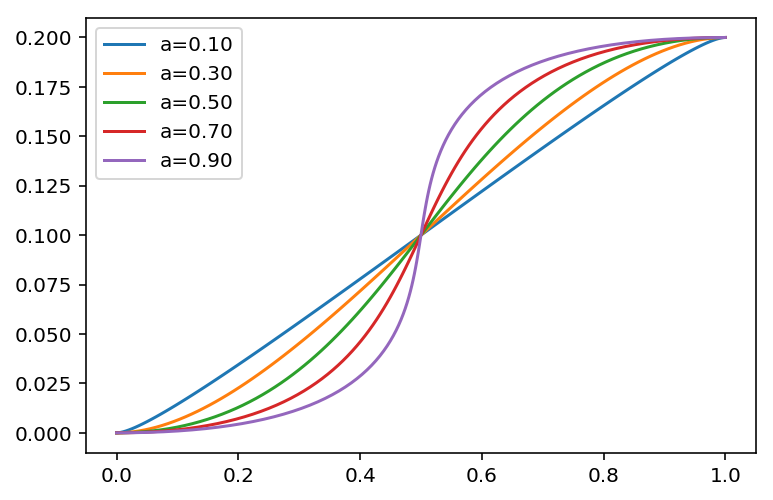

In [4]:
plt.figure()
t = np.linspace(0, 1, 100)
for a in np.linspace(0.1, 0.9, 5):
    r, s = 1, 0.2
    P0 = Point(0, 0)
    P1 = P0 + Point(a, 0)
    P3 = Point(r, s)
    P2 = P3 - Point(a, 0)
    bezier = bezier_line(P0, P1, P2, P3)(t)
    plt.plot(bezier.x, bezier.y, label=f'a={a:.2f}')
plt.legend()
plt.show()

a, max_curv
0.30 1.48
0.40 0.87
0.50 1.00
0.60 1.52
0.70 2.67


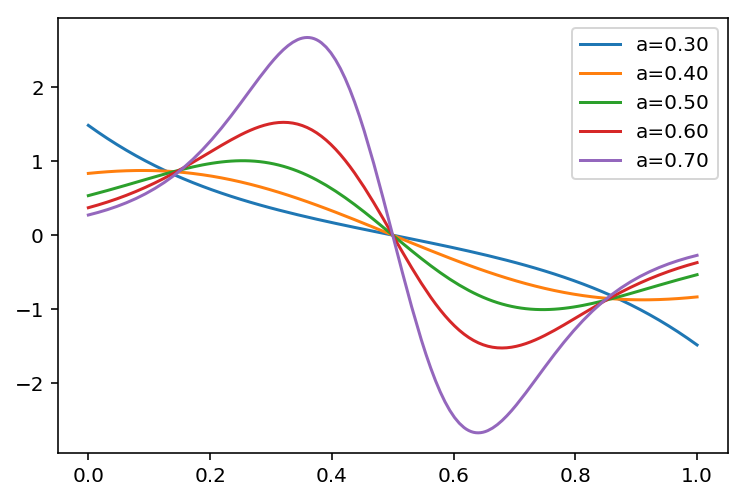

In [5]:
plt.figure()
#t = np.linspace(0, 1, 200)
print("a, max_curv")
for a in np.linspace(0.3, 0.7, 5):
    r, s = 1, 0.2
    P0 = Point(0, 0)
    P1 = P0 + Point(a, 0)
    P3 = Point(r, s)
    P2 = P3 - Point(a, 0)
    t, curv = sample_function(curvature_bezier(P0, P1, P2, P3), [0, 1])
    print(f"{a:.2f}", "{:.2f}".format(np.max(curv)))
    plt.plot(t, curv.T, label=f'a={a:.2f}')
plt.legend()
plt.show()

Best Bézier curves

Min radius: 1.49 um
Total length: 1.003 um
Min radius: 0.58 um
Total length: 1.017 um
Min radius: 0.36 um
Total length: 1.047 um
Min radius: 0.26 um
Total length: 1.096 um
Min radius: 0.20 um
Total length: 1.162 um
Min radius: 0.16 um
Total length: 1.245 um
Min radius: 0.14 um
Total length: 1.331 um
Min radius: 0.12 um
Total length: 1.421 um
Min radius: 0.10 um
Total length: 1.500 um
Min radius: 0.09 um
Total length: 1.553 um


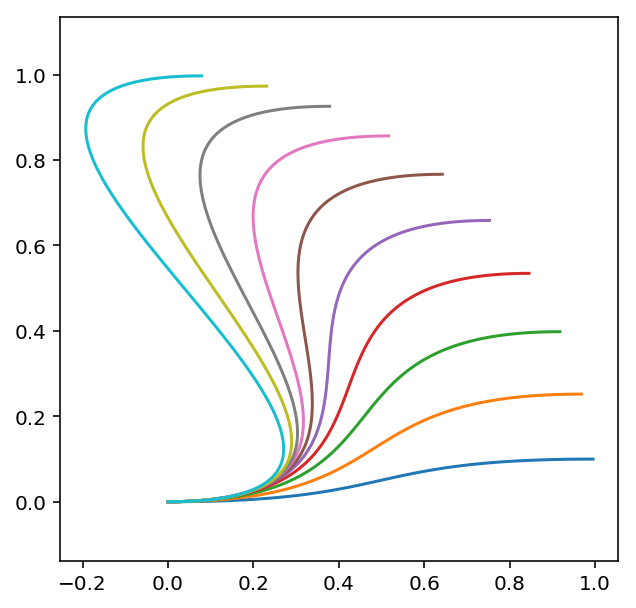

In [7]:
P0 = Point(0,0)
θ_list = np.linspace(0.1,np.pi*0.95/2,10)
P3_list = [Point(np.cos(θ), np.sin(θ)) for θ in θ_list]

fig = plt.figure(figsize=(5, 5))
t = np.linspace(0, 1, 100)
for P3 in P3_list:
    bezier = bezier_horizontal(P0, P3)(t)
    plt.plot(bezier.x, bezier.y)
fig.axes[0].set_aspect('equal', 'datalim')
plt.show()

Min radius: inf um
Total length: 1.000 um
Min radius: 1.42 um
Total length: 1.003 um
Min radius: 0.71 um
Total length: 1.011 um
Min radius: 0.47 um
Total length: 1.027 um
Min radius: 0.35 um
Total length: 1.050 um
Min radius: 0.28 um
Total length: 1.081 um
Min radius: 0.23 um
Total length: 1.122 um
Min radius: 0.20 um
Total length: 1.170 um
Min radius: 0.17 um
Total length: 1.224 um
Min radius: 0.15 um
Total length: 1.285 um
Min radius: 0.13 um
Total length: 1.342 um
Min radius: 0.12 um
Total length: 1.402 um
Min radius: 0.11 um
Total length: 1.454 um
Min radius: 0.10 um
Total length: 1.508 um
Min radius: 0.09 um
Total length: 1.563 um
Min radius: 0.08 um
Total length: 1.582 um


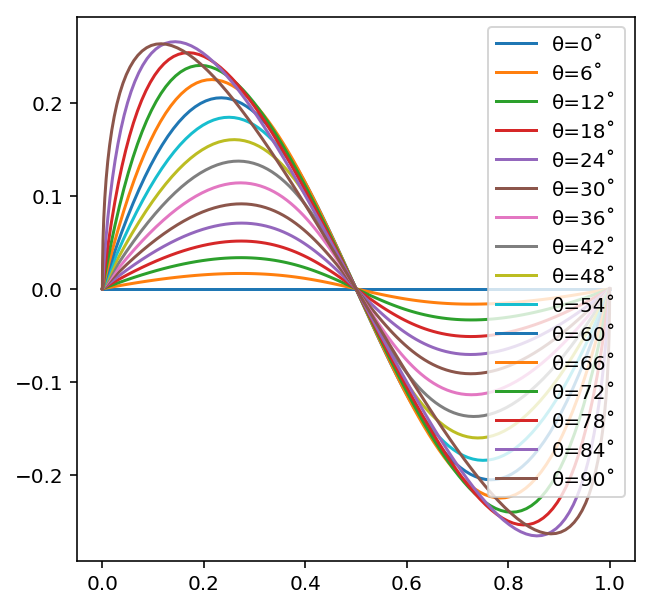

In [8]:
P0 = Point(0,0)
P3 = Point(1,0)
θ_list = np.linspace(0,np.pi*0.5,16) * 180/np.pi

plt.figure(figsize=(5, 5))
t = np.linspace(0, 1, 100)
for θ in θ_list:
    bezier = bezier_parallel(P0, P3, θ)(t)
    plt.plot(bezier.x, bezier.y, label=f"θ={θ:.0f}˚")
plt.legend()
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

Min radius: 0.07 um
Total length: 1.466 um
Min radius: 0.10 um
Total length: 1.324 um
Min radius: 0.14 um
Total length: 1.235 um
Min radius: 0.26 um
Total length: 1.305 um
Min radius: 0.37 um
Total length: 1.523 um
Min radius: 0.41 um
Total length: 1.711 um
Min radius: 0.42 um
Total length: 1.923 um
Min radius: 0.37 um
Total length: 2.225 um
Min radius: 0.50 um
Total length: 2.318 um
Min radius: 0.48 um
Total length: 2.579 um
Min radius: 0.37 um
Total length: 3.006 um
Min radius: 0.36 um
Total length: 3.342 um
Min radius: 0.45 um
Total length: 3.528 um
Min radius: 0.50 um
Total length: 3.776 um
Min radius: 0.45 um
Total length: 4.200 um
Min radius: 0.42 um
Total length: 4.598 um
Min radius: 0.43 um
Total length: 4.928 um
Min radius: 0.49 um
Total length: 5.171 um
Min radius: 0.54 um
Total length: 5.447 um
Min radius: 0.49 um
Total length: 5.901 um


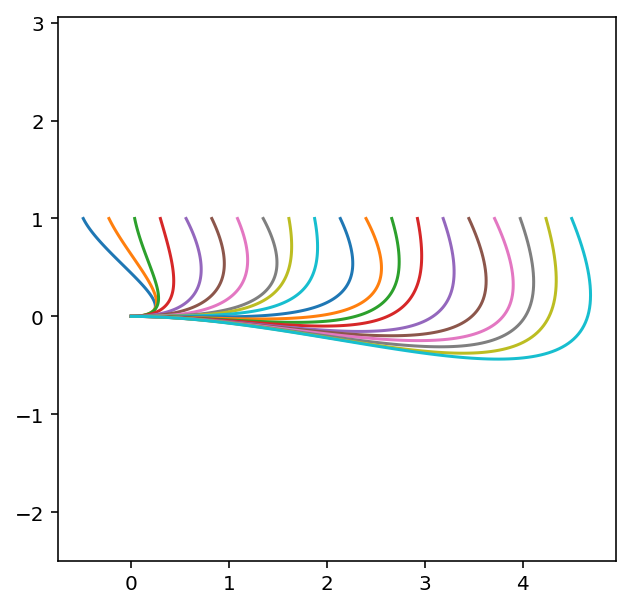

In [9]:
fig = plt.figure(figsize=(5, 5))
t = np.linspace(0, 1, 100)

for x in np.linspace(0.01, 5, 20):
    P0 = Point(0, 0)
    P3 = Point(x-.5, 1)
    angle0, angle3 = 0, 100 + np.random.random() * 20
    bezier = bezier_optimal(P0, P3, angle0, angle3)(t)
    plt.plot(bezier.x, bezier.y)
fig.axes[0].set_aspect('equal', 'datalim')
plt.show()

Min radius: 9.75 um
Total length: 5.006 um
Min radius: 4.56 um
Total length: 5.036 um
Min radius: 3.62 um
Total length: 5.077 um
Min radius: 2.95 um
Total length: 5.139 um
Min radius: 2.76 um
Total length: 5.207 um
Min radius: 2.10 um
Total length: 5.340 um
Min radius: 1.94 um
Total length: 5.460 um
Min radius: 1.69 um
Total length: 5.631 um
Min radius: 1.66 um
Total length: 5.771 um
Min radius: 1.59 um
Total length: 5.951 um
Min radius: 1.42 um
Total length: 6.197 um
Min radius: 1.40 um
Total length: 6.411 um
Min radius: 1.31 um
Total length: 6.686 um
Min radius: 1.34 um
Total length: 6.886 um
Min radius: 1.24 um
Total length: 7.240 um
Min radius: 1.25 um
Total length: 7.497 um
Min radius: 1.23 um
Total length: 7.795 um
Min radius: 1.21 um
Total length: 8.104 um
Min radius: 1.16 um
Total length: 8.500 um
Min radius: 1.19 um
Total length: 8.763 um


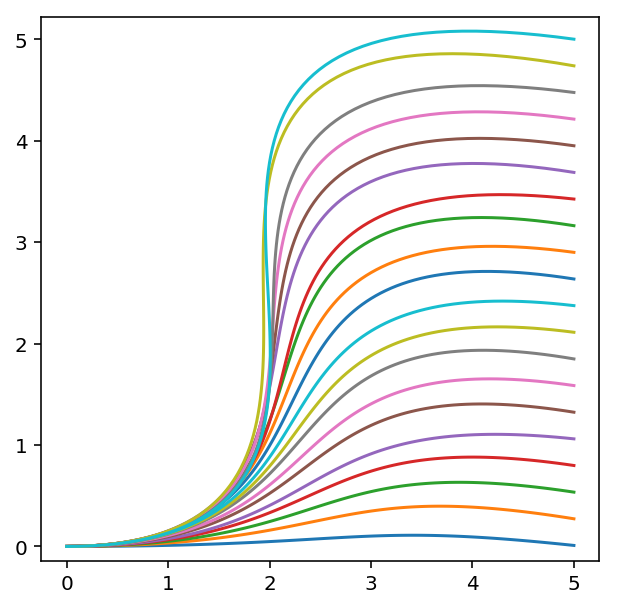

In [10]:
fig = plt.figure(figsize=(5, 5))
t = np.linspace(0, 1, 100)

for x in np.linspace(0.01, 5, 20):
    P0 = Point(0, 0)
    P3 = Point(5, x)
    angle0, angle3 = 0, -10 + np.random.rand()*4
    bezier = bezier_optimal(P0, P3, angle0, angle3)(t)
    plt.plot(bezier.x, bezier.y)
fig.axes[0].set_aspect('equal', 'datalim')
plt.show()

Min radius: 0.52 um
Total length: 2.057 um


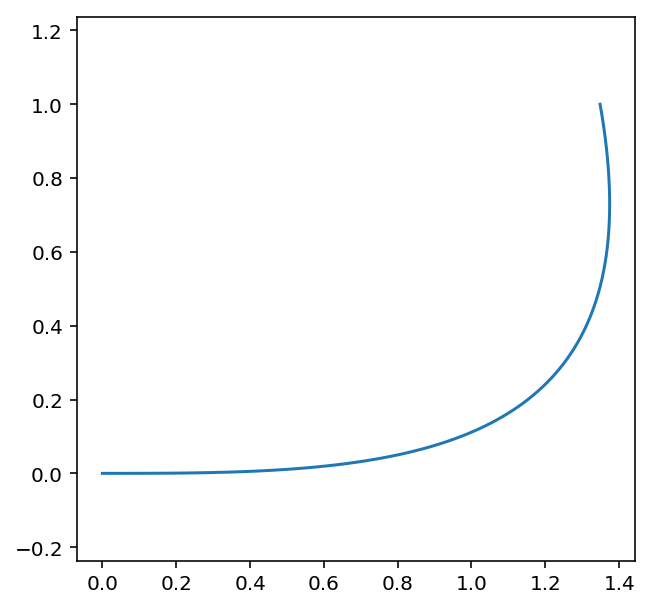

In [11]:
fig = plt.figure(figsize=(5, 5))
t = np.linspace(0, 1, 100)

x = 1.848421052631579
P0 = Point(0, 0)
P3 = Point(x-.5, 1)
angle0, angle3 = 0, 100
bezier = bezier_optimal(P0, P3, angle0, angle3)(t)
plt.plot(bezier.x, bezier.y)
fig.axes[0].set_aspect('equal', 'datalim')
plt.show()

Min radius: 0.63 um
Total length: 1.604 um
Min radius: 0.65 um
Total length: 1.611 um
Min radius: 0.66 um
Total length: 1.617 um
Min radius: 0.67 um
Total length: 1.622 um
Min radius: 0.68 um
Total length: 1.629 um
Min radius: 0.68 um
Total length: 1.637 um
Min radius: 0.67 um
Total length: 1.646 um
Min radius: 0.62 um
Total length: 1.669 um
Min radius: 0.60 um
Total length: 1.685 um
Min radius: 0.58 um
Total length: 1.701 um


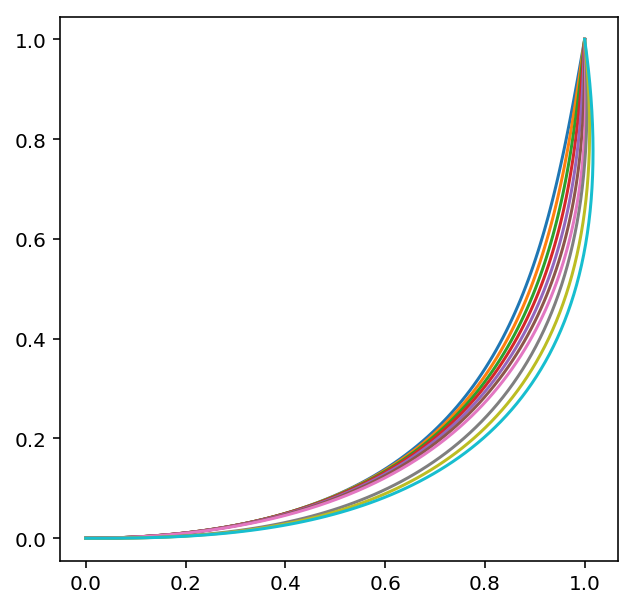

In [12]:
fig = plt.figure(figsize=(5, 5))
t = np.linspace(0, 1, 100)
P0 = Point(0, 0)
P3 = Point(1, 1)
for x in range(10):
    angle0, angle3 = 0, 80 + x*2
    bezier = bezier_optimal(P0, P3, angle0, angle3)(t)
    plt.plot(bezier.x, bezier.y)
fig.axes[0].set_aspect('equal', 'datalim')
plt.show()